In [1]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
X,y=load_boston().data,load_boston().target
X=StandardScaler().fit_transform(X)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [2]:
from sklearn.linear_model import LinearRegression as sklearn_lr
model=sklearn_lr().fit(X_train,y_train)
print(model.coef_)
print(model.intercept_)

[-0.94143838  1.1287826   0.07438234  1.12235433 -2.29374121  2.48821872
  0.05572293 -3.16926165  2.51283366 -2.06039687 -1.97428145  0.83797315
 -3.57529846]
22.468140353706968


In [3]:
model.predict(X_test)[:10]

array([12.72262381, 13.09383239, 20.94223235, 12.30233834, 25.10280754,
       31.87325106, 30.89709974, 22.23871446, 27.07151506,  6.53649435])

### 1.使用Scipy optimize求解线性回归

In [4]:
from scipy.optimize import lsq_linear
class LinearRegression:
    def fit(self,X,y):
        _,n=np.shape(X)
        X=np.insert(X,n,1,axis=1)          #将X新增一列为1的列向量
        A = X
        b = y
        res = lsq_linear(A, b, lsmr_tol='auto', verbose=1)
        self.coef_=res.x[:-1]
        self.intercept_=res.x[-1]
        self.res=res
        return self
    def predict(self,X):
        return np.array(X@self.coef_.reshape(-1,1)+self.intercept_).flatten()
           
model=LinearRegression().fit(X_train,y_train)
model.predict(X_test)[:5]

The unconstrained solution is optimal.
Final cost 3.9676e+03, first-order optimality 8.84e-12


array([12.72262381, 13.09383239, 20.94223235, 12.30233834, 25.10280754])

### 3.使用Scipy求解带L2正则化的线性回归

In [5]:
class Ridge:
    def __init__(self,c=0.0001):
        self.c=c
    def fit(self,X,y):
        init_w=np.random.randn(X.shape[1]+1)
        res=minimize(type(self).loss,init_w,args=(X,y))
        self.coef_=res.x[:-1]
        self.intercept_=res.x[-1]
        return self
    def predict(self,X):
        pred=X@self.coef_.T+self.intercept_
        regularization=self.c*self.coef_.T@self.coef_
        return pred+regularization
    
    def loss(w,X,y,c=0.1):
        _,n=np.shape(X)
        X=np.insert(X,n,1,axis=1)          #将X新增一列为1的列向量                                                 
        loss=np.square(y-X@w).sum()+c*np.square(w[:-1]).sum()    #minmize ||y - Xw||^2_2 + alpha * ||w||^2_2
        return loss
model=Ridge().fit(X_train,y_train)
pre=model.predict(X_test)
pre[:10]

array([12.7285475 , 13.10619371, 20.9509583 , 12.3103204 , 25.10814947,
       31.87015367, 30.89549084, 22.24203821, 27.07405286,  6.54539661])

In [6]:
from sklearn.linear_model import Ridge as sklearn_Ridge
model=sklearn_Ridge(alpha=0.0001).fit(X_train,y_train)
pre2=model.predict(X_test)
pre2[:10]

array([12.72262446, 13.09383949, 20.94223582, 12.30234105, 25.10280762,
       31.87324267, 30.89709284, 22.2387125 , 27.07151231,  6.53649799])

### 3.使用梯度下降法求解线性回归

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
class LinearRegression:
    def __init__(self,learning_rate=0.03,max_iters=50):
        self.learning_rate=learning_rate
        self.max_iters=max_iters
    def fit(self,X,y):
        m,n=np.shape(X)
        X=np.insert(X,n,1,axis=1)          #将X新增一列为1的列向量
        W=np.random.randn(X.shape[1])
        loss_series=[]
        for i in range(self.max_iters):
            error=X@W.T-y
            grad=(2*X.T@error)/m
            W=W-self.learning_rate*grad  #更新权重
            current_loss=np.square(error).sum()/m
            loss_series.append(current_loss)
        plt.plot(range(self.max_iters),loss_series,color='black')
        plt.xlabel('The number of iterations')
        plt.ylabel('The mean square error')
        self.W=W
        self.coef_=W[:-1]
        self.intercept=W[:-1]
        
        return self
    def predict(self,X):
        X_=np.full(shape=(X.shape[0],1),fill_value=1)
        X=np.concatenate([X,X_],axis=1)
        pre=X@self.W.T
        return pre

21.719792892598857

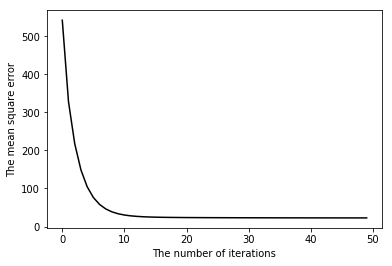

In [8]:
lr=LinearRegression(learning_rate=0.1).fit(X_train,y_train)
mean_squared_error(y_test,lr.predict(X_test))

### 4.使用随机梯度下降法

In [9]:
class LinearRegression:
    def __init__(self,learning_rate=0.03,max_iters=100):
        self.learning_rate=learning_rate
        self.max_iters=max_iters
    def fit(self,X,y):
        m,n=np.shape(X)
        X=np.insert(X,n,1,axis=1)          #将X新增一列为1的列向量
        W=np.random.randn(X.shape[1])
        loss_series=[]
        for i in range(self.max_iters):
            dataIndex=list(range(m))
            for j in range(m):
                alpha = 4/(1.0+j+i)+0.001   
                randIndex = int(np.random.uniform(0,len(dataIndex)))  #随机挑选一个样本进行迭代                       
                error=X[randIndex]@W.T-y[randIndex]
                grad=(X[randIndex].T*error)/m
                W=W-self.learning_rate*grad  #更新权重
                del (dataIndex[randIndex])
            current_loss=np.square(error).sum()/m
            loss_series.append(current_loss)
        plt.plot(range(self.max_iters),loss_series,color='black')
        plt.xlabel('The number of iterations')
        plt.ylabel('The mean square error')
        self.W=W
        self.coef_=W[:-1]
        self.intercept=W[:-1]
        
        return self
    def predict(self,X):
        X_=np.full(shape=(X.shape[0],1),fill_value=1)
        X=np.concatenate([X,X_],axis=1)
        pre=X@self.W.T
        return pre

22.77542357974661

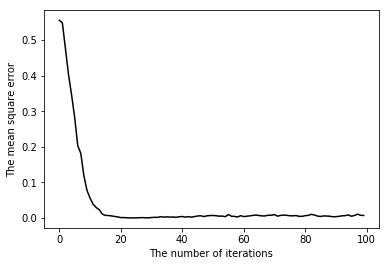

In [10]:
lr=LinearRegression(learning_rate=0.1).fit(X_train,y_train)
mean_squared_error(y_test,lr.predict(X_test))